In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import utils
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
def filter_by_prefix(df,prefix):
    '''
    Filter case by prefix length
    
    Parameters
    ----------
    df : pandas dataframe
        Assigned dataframe to slice by prefix length
    
    prefix : int
        Prefix length to slice to cases in fixed length
    
    Returns
    ----------
    Return dataframe with sliced cases
    '''
    df['ts'] = pd.to_datetime(df['ts'])
    groups = df.groupby('caseid')
    encoded_df=[]
    for case,group in groups: 
        group = group.reset_index(drop=True)
        if len(group)>prefix:
            group = group.loc[:prefix-1,:]
            encoded_df.append(group)
    return pd.concat(encoded_df)

In [3]:
def aggregation_encoding(df, prefix):
    '''
    Aggregation encoding
    
    Parameters
    ----------
    df : pandas dataframe
        Assigned dataframe to encode for outcome prediction
    
    prefix : int
        Prefix length to slice to cases in fixed length
    
    Returns
    ----------
    Return dataframe encoded in aggregation method
    '''
    df = filter_by_prefix(df,prefix)
    df['ts'] = pd.to_datetime(df['ts'])
    groups = df.groupby('caseid')
    encoded_df=[]
    for case,group in groups: 
        group = group.reset_index(drop=True)
        outcome = set(group['outcome']).pop()
        cumdurationlist = [(x - list(group['ts'])[0]).total_seconds() for x in list(group['ts'])]
        case_time_outcome = {'caseid':case, 'ts':np.mean(cumdurationlist),'outcome':outcome}
        activity_count = {x: list(group['activity']).count(x) for x in set(group['activity'])}
        resource_count = {x: list(group['resource']).count(x) for x in set(group['resource'])}

        case_time_outcome.update(activity_count)
        case_time_outcome.update(resource_count)
        dfk = pd.DataFrame.from_dict([case_time_outcome])
        encoded_df.append(dfk)
    concated_df = pd.concat(encoded_df)
    concated_df = concated_df.fillna(0)
    return concated_df

In [35]:
def indexbase_encoding(df, prefix):
    '''
    Indexbase encoding
    
    Parameters
    ----------
    df : pandas dataframe
        Assigned dataframe to encode for outcome prediction
    
    prefix : int
        Prefix length to slice to cases in fixed length
    
    Returns
    ----------
    Return dataframe encoded in indexbase method
    '''
    df = filter_by_prefix(df,prefix)
    df['ts'] = pd.to_datetime(df['ts'])
    groups = df.groupby('caseid')
    encoded_df=[]
    for case,group in groups: 
        activitylist = list(group['activity'])
        resourcelist = list(group['resource'])
        group = group.reset_index(drop=True)
        outcome = set(group['outcome']).pop()
        cumdurationlist = [(x - list(group['ts'])[0]).total_seconds() for x in list(group['ts'])]
        cumduration_index ={'Cumduration_'+str(x+1): cumdurationlist[x] for x in range(len(cumdurationlist))}
        case_outcome = {'caseid':case, 'outcome':outcome}
        activity_index = {'activity_'+str(x+1)+'_'+activitylist[x]: 1 for x in range(len(activitylist))}
        resource_index = {'resource_'+str(x+1)+'_'+str(resourcelist[x]): 1 for x in range(len(resourcelist))}
        case_outcome.update(cumduration_index)
        case_outcome.update(activity_index)
        case_outcome.update(resource_index)
        dfk = pd.DataFrame.from_dict([case_outcome])
        encoded_df.append(dfk)
    concated_df = pd.concat(encoded_df)
    concated_df = concated_df.fillna(0)
    return concated_df

In [5]:
df = pd.read_csv('./data/bpic2017.csv')
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])
df = df.rename(columns={'Case ID':'caseid','Activity':'activity','Complete Timestamp':'ts','Resource':'resource'})
df = df.loc[:,['caseid','activity','ts','resource']]
groups = df.groupby('caseid')
reconcatenate =[]
for _,group in groups:
    group = group.reset_index(drop=True)
    case_label = utils.set_label(group.iloc[-1,:].to_dict())['True label']
    group.loc[:,'outcome'] = case_label
    reconcatenate.append(group)
dfn = pd.concat(reconcatenate)
# df2 = aggregation_encoding(dfn,2)
df3 = aggregation_encoding(dfn,3)
df4 = aggregation_encoding(dfn,4)
idf3 = indexbase_encoding(dfn,3)
idf4 = indexbase_encoding(dfn,4)

In [6]:
print('BPIC2017 aggregation encoding with prefix length 3')
y = df3['outcome']
x =df3.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 3
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.58      0.01      0.02       575
Not accepted       0.61      0.99      0.75       884

    accuracy                           0.61      1459
   macro avg       0.60      0.50      0.39      1459
weighted avg       0.60      0.61      0.47      1459



BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.74      0.96      0.84       568
Not accepted       0.31      0.05      0.09       197

    accuracy                           0.73       765
   macro avg       0.53      0.51      0.46       765
weighted avg       0.63      0.73      0.65       765



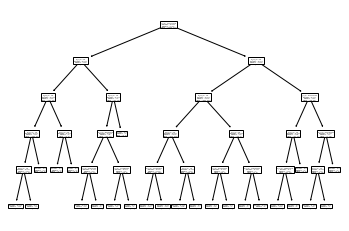

In [8]:
tree.plot_tree(dt)
# plt.show()
plt.savefig('./img/offlinetree.png',dpi=300)

In [9]:
print('BPIC2017 index encoding with prefix length 3')
y = idf3['outcome']
x =idf3.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 index encoding with prefix length 3
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.48      0.05      0.10       566
Not accepted       0.62      0.96      0.75       893

    accuracy                           0.61      1459
   macro avg       0.55      0.51      0.42      1459
weighted avg       0.56      0.61      0.50      1459



In [11]:
print('BPIC2017 aggregation encoding with prefix length 4')
y = df4['outcome']
x =df4.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.73      0.99      0.84       563
Not accepted       0.11      0.00      0.01       202

    accuracy                           0.73       765
   macro avg       0.42      0.50      0.43       765
weighted avg       0.57      0.73      0.62       765



In [12]:
print('BPIC2017 index encoding with prefix length 4')
y = idf4['outcome']
x =idf4.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 index encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

    Accepted       0.71      0.98      0.82       543
Not accepted       0.29      0.02      0.03       222

    accuracy                           0.70       765
   macro avg       0.50      0.50      0.43       765
weighted avg       0.59      0.70      0.59       765



In [39]:
df = pd.read_csv('./data/BPIC15_1prep.csv')
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])
df = df.rename(columns={'Case ID':'caseid','Activity':'activity','Complete Timestamp':'ts','Resource':'resource','Label':'outcome'})
df = df.loc[:,['caseid','activity','ts','resource','outcome']]
groups = df.groupby('caseid')
reconcatenate =[]
for _,group in groups:
    group = group.reset_index(drop=True)
    case_label = list(group['outcome'])[0]#utils.set_label(group.iloc[-1,:].to_dict())['True label']
    group.loc[:,'outcome'] = case_label
    reconcatenate.append(group)
dfn = pd.concat(reconcatenate)
# df2 = aggregation_encoding(dfn,2)

df4 = aggregation_encoding(dfn,4)
df8 = aggregation_encoding(dfn,8)

idf4 = indexbase_encoding(dfn,4)
idf8 = indexbase_encoding(dfn,8)

/home/iel03/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [40]:
print('BPIC2017 aggregation encoding with prefix length 4')
y = df4['outcome']
x =df4.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.99      0.86       268
           1       0.57      0.04      0.08        90

    accuracy                           0.75       358
   macro avg       0.66      0.52      0.47       358
weighted avg       0.71      0.75      0.66       358



In [41]:
print('BPIC2017 index encoding with prefix length 4')
y = idf4['outcome']
x =idf4.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 index encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       274
           1       0.00      0.00      0.00        84

    accuracy                           0.77       358
   macro avg       0.38      0.50      0.43       358
weighted avg       0.59      0.77      0.66       358



/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iel03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print('BPIC2017 aggregation encoding with prefix length 4')
y = df8['outcome']
x =df8.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       264
           1       0.67      0.07      0.12        87

    accuracy                           0.76       351
   macro avg       0.71      0.53      0.49       351
weighted avg       0.74      0.76      0.68       351



In [43]:
print('BPIC2017 aggregation encoding with prefix length 4')
y = idf8['outcome']
x =idf8.drop(columns=['outcome','caseid'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

# Deicision tree result
print('Decision Tree')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(x_train,y_train)
y_pred = dt.predict(x_test)
print(classification_report(y_test,y_pred))

BPIC2017 aggregation encoding with prefix length 4
Decision Tree
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       263
           1       0.35      0.14      0.20        88

    accuracy                           0.72       351
   macro avg       0.56      0.53      0.51       351
weighted avg       0.66      0.72      0.67       351

